# **SimCLR with TensorFlow - 2**
## Linear Evaluation
**This colab shows training with 10% of the data available using the learned representations (from simCLR) - linear evaluation**

The colab also experiments with wandb:

Weights & Biases is the machine learning platform to build better models faster. W&B uses lightweight, interoperable tools to quickly track experiments, version and iterate on datasets, evaluate model performance, reproduce models, visualize results and spot regressions, and share findings.

### References:
1. https://github.com/sayakpaul/SimCLR-in-TensorFlow-2
2. https://docs.wandb.ai/


In [1]:
##Checking tensorflow version
import tensorflow as tf
print(tf.__version__)

2.6.0


Get the track of GPU activity while executing your deep learning or data science tasks

In [2]:
!nvidia-smi

Sat Sep 25 22:39:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

  Using cached https://github.com/wandb/client/archive/feature/code-save.zip
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=414cee4054736394e51084b61e6e996e3c4fce90f0b2a8f422c5dd4410be6c15
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
Successfully built wandb
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.11
    Uninstalling wandb-0.10.11:
      Successfully uninstalled wandb-0.10.11


In [ ]:
##Upgrading the version of wandb as the WandbCallback import requires a higher version
!pip install wandb==0.10.11

In [4]:
import wandb
wandb.login()

True

In [ ]:
# pip install wandb --upgrade

## **Restoring model weights from wandb run page**

In [5]:
##Checking working directory
%pwd

'/content'

In [6]:
##Mounting the drive in order to load the model weights trained with the SimCLR colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb.init() spawns a new background process to log data to a run, and it also syncs data to wandb.ai by default so as to see live visualizations.

In [7]:
wandb.init()

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/arpithagurumurthy/uncategorized/runs/15h7xk7p

In [8]:
##Loading the representations learned using simCLR
simclr_weights = wandb.restore("/content/drive/MyDrive/CMPE297_HW1/resnet_simclr_Arpitha_latest.h5")

In [ ]:
# !pip install wandb

In [9]:
# Necessary imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## **Downloading and preparing the dataset**

In [10]:
# cloning the imagenet's subset - dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [11]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [12]:
# Using only 10% of the dataset for training 
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [13]:
##Dataset preparation
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [14]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 127.36it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 172.54it/s]


(250, 224, 224, 3) (250,)


In [15]:
##Label encoding the target labels for train and test 
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## **Model Architecture**

In [16]:
# Architecture 
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    ## 3 represents the R, G, B and 224 is the image size
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    ##Required for the representations
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [17]:
## 256 is the input and 128 represents the dimensions of the representation to be learnt
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [18]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [19]:
##Softmax is used as it is a multiclass classification
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## **Model Evaluation**

In [20]:
##Finetuning the above resnet model
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [21]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [22]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 1s 227ms/step - loss: 9.6782 - accuracy: 0.2640 - val_loss: 8.8843 - val_accuracy: 0.2400
Epoch 2/35
2/2 [==============================] - 0s 66ms/step - loss: 8.6013 - accuracy: 0.2480 - val_loss: 7.9057 - val_accuracy: 0.2360


Streaming file created twice in same run: /content/wandb/run-20210925_224148-linear-eval-relu-last/wandb-events.jsonl


Epoch 3/35
2/2 [==============================] - 0s 42ms/step - loss: 7.6363 - accuracy: 0.2480 - val_loss: 7.0021 - val_accuracy: 0.2600
Epoch 4/35
2/2 [==============================] - 0s 35ms/step - loss: 6.7442 - accuracy: 0.3040 - val_loss: 6.2631 - val_accuracy: 0.2840
Epoch 5/35
2/2 [==============================] - 0s 33ms/step - loss: 6.0915 - accuracy: 0.3200 - val_loss: 5.6843 - val_accuracy: 0.2880
Epoch 6/35
2/2 [==============================] - 0s 49ms/step - loss: 5.6380 - accuracy: 0.3520 - val_loss: 5.2321 - val_accuracy: 0.3000
Epoch 7/35
2/2 [==============================] - 0s 37ms/step - loss: 5.2214 - accuracy: 0.3040 - val_loss: 4.8785 - val_accuracy: 0.2960
Epoch 8/35
2/2 [==============================] - 0s 33ms/step - loss: 4.9316 - accuracy: 0.3120 - val_loss: 4.6000 - val_accuracy: 0.3040
Epoch 9/35
2/2 [==============================] - 0s 31ms/step - loss: 4.7043 - accuracy: 0.3360 - val_loss: 4.3653 - val_accuracy: 0.3160
Epoch 10/35
2/2 [==========

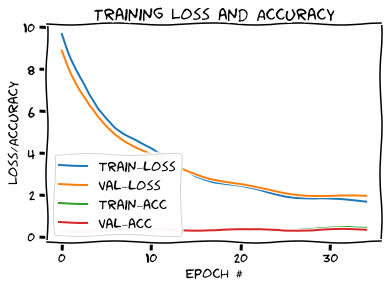

In [23]:
# Linear model
wandb.init(project="simclr", id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In order for 128 dimensional representations, above is the graph.
With **resnet_simclr.layers[-2]**


In [24]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 1s 174ms/step - loss: 4.9382 - accuracy: 0.1920 - val_loss: 4.1392 - val_accuracy: 0.1920
Epoch 2/35
2/2 [==============================] - 0s 39ms/step - loss: 4.1719 - accuracy: 0.1680 - val_loss: 3.6839 - val_accuracy: 0.1640
Epoch 3/35
2/2 [==============================] - 0s 35ms/step - loss: 3.7577 - accuracy: 0.2400 - val_loss: 3.4546 - val_accuracy: 0.1840
Epoch 4/35
2/2 [==============================] - 0s 48ms/step - loss: 3.5944 - accuracy: 0.2560 - val_loss: 3.2779 - val_accuracy: 0.2000
Epoch 5/35
2/2 [==============================] - 0s 48ms/step - loss: 3.3855 - accuracy: 0.2400 - val_loss: 3.0667 - val_accuracy: 0.2040
Epoch 6/35
2/2 [==============================] - 0s 32ms/step - loss: 3.1382 - accuracy: 0.2400 - val_loss: 2.8364 - val_accuracy: 0.1920
Epoch 7/35
2/2 [==============================] - 0s 32ms/step - loss: 2.9026 - accuracy: 0.2160 - val_loss: 2.6227 - val_accuracy: 0.2040
Epoch 8/35
2/2 [==========

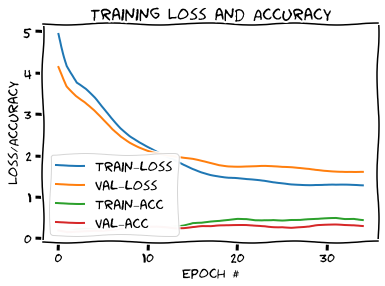

In [25]:
wandb.init(project="simclr", id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

With **resnet_simclr.layers[-4]**

In [26]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/35
2/2 [==============================] - 0s 176ms/step - loss: 2.4152 - accuracy: 0.2480 - val_loss: 2.3458 - val_accuracy: 0.1840
Epoch 2/35
2/2 [==============================] - 0s 43ms/step - loss: 2.5857 - accuracy: 0.2160 - val_loss: 2.1873 - val_accuracy: 0.2280
Epoch 3/35
2/2 [==============================] - 0s 45ms/step - loss: 2.0588 - accuracy: 0.2560 - val_loss: 1.5770 - val_accuracy: 0.3640
Epoch 4/35
2/2 [==============================] - 0s 41ms/step - loss: 1.5044 - accuracy: 0.3680 - val_loss: 1.8695 - val_accuracy: 0.2280
Epoch 5/35
2/2 [==============================] - 0s 53ms/step - loss: 1.6961 - accuracy: 0.3120 - val_loss: 1.9422 - val_accuracy: 0.2480
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


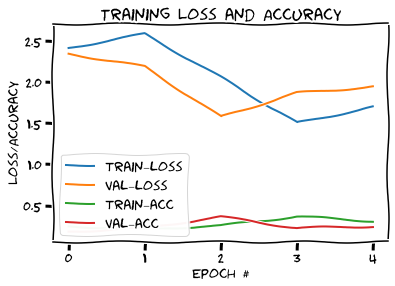

In [27]:
wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

With **resnet_simclr.layers[-6]**

## Visualization of the representations

In [28]:
wandb.init(project="simclr", id="visualization")

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/arpithagurumurthy/simclr/runs/visualization

In [29]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

**This is with only the base encoder network i.e. without any non-linear projections.**


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


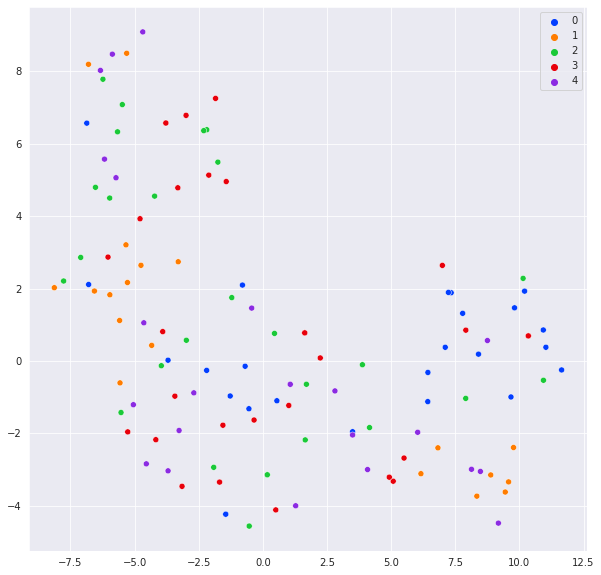

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [30]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

**Representations with one hidden layer - ReLu**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



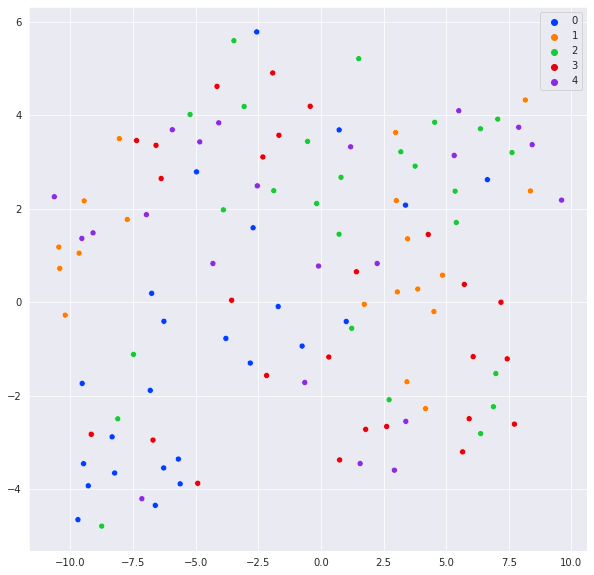

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [31]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"second_last_relu": fig})

**Representations with 2 hidden layers - ReLu**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



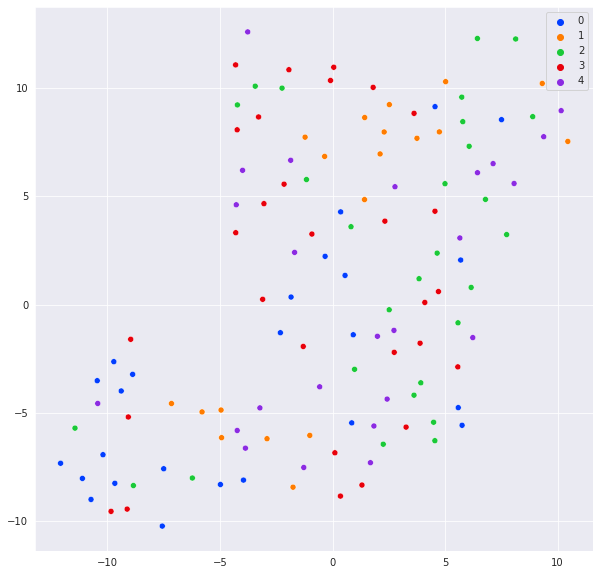

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [32]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})